In [28]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from Plane import Plane
from PID import PID
import setpoints

In [29]:
env = Plane(data_path="Data/Mp(10alpha).csv", reward_type='L1+Gauss', evaluate=True)

In [31]:
pid = PID()
ddpg = load_model('DDPG_models/final/actor.h5')

In [22]:
def test_ddpg(ddpg, env, SP, n_max_steps=200, seed=42):
    action_bound_range = np.deg2rad(30)
    all_obs = np.empty((len(SP), 4))
    obs = env.reset()
    #obs = [0.0, 0.0, 0.0, 0.0]
    for step in range(len(SP)):
        #print(obs)
        all_obs[step,:] = np.array(obs)
        env.set_setpoint(SP[step])
        state = tf.convert_to_tensor([obs], dtype=tf.float32)
        action = action_bound_range*ddpg(state)
        obs, reward, done, info = env.step(action)
            
    return all_obs

In [23]:
def test_pid(pid, env, SP):
    all_obs = np.empty((len(SP), 4))
    obs = env.reset()
    obs = [0.0, 0.0, 0.0, 0.0]
    for step in range(len(SP)):
        all_obs[step,:] = np.array(obs)
        env.set_setpoint(SP[step])
        action = pid.control(SP[step], obs[0], env.tau)
        obs, reward, done, info = env.step(action)
            
    return all_obs

In [24]:
SP, t = setpoints.get_SP('complex_purposive')

In [25]:
obs_ddpg = test_ddpg(ddpg, env, SP)

In [26]:
obs_pid = test_pid(pid, env, SP)

In [27]:
def plot_results_comparision(obs_pid, obs_ddpg, SP):
    
    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    dt = env.tau
    num = len(SP)
    t_end =  dt* num
    t = np.linspace(0.0, t_end, num)

    obs_pid = np.rad2deg(obs_pid)
    obs_ddpg = np.rad2deg(obs_ddpg)

    fig = plt.figure(figsize=(10,16))
    
    plt.subplot(3,1,1)
    
    plt.plot(t, obs_pid[:,0], label="PID", linewidth=2)
    plt.plot(t, obs_ddpg[:,0], 'green',label="DDPG", linewidth=2)
    plt.plot(t, np.rad2deg(SP), 'darkorange',label='Nastawa', linewidth=2)
    plt.xlim((0.0, t_end))
    plt.ylabel('Kąt $[^o]$')
    plt.xlabel('Czas [s]')
    plt.legend(loc='lower right')
    plt.title("Pochylenie samolotu", fontsize=18)
    plt.grid()

    plt.subplot(3,1,2)

    plt.plot(t, obs_ddpg[:,2], 'green',label="DDPG", linewidth=2)
    plt.plot(t, obs_pid[:,2], label="PID", linewidth=2)
    plt.xlim((-0.0, t_end))
    plt.ylabel('Kąt $[^o]$')
    plt.xlabel('Czas [s]')
    plt.legend(loc='lower right')
    plt.title("Wychylenie usterzenia poziomego", fontsize=18)
    plt.grid()

    plt.subplot(3,1,3)

    error_sum_pid = np.empty(num)
    error_sum_pid[0] =  obs_pid[0,3]*dt
    error_sum_ddpg = np.empty(num)
    error_sum_ddpg[0] =  obs_pid[0,3]*dt
    for i in range(1,num):
        error_sum_pid[i] = error_sum_pid[i-1] + abs(obs_pid[i,3]*dt)
        error_sum_ddpg[i] = error_sum_ddpg[i-1] + abs(obs_ddpg[i,3]*dt)
    plt.plot(t, error_sum_ddpg,'green', label="DDPG", linewidth=2)
    plt.plot(t, error_sum_pid, label="PID", linewidth=2)
    plt.xlim((-0.0, t_end))
    plt.xlabel('Czas [s]')
    plt.ylabel('Scałkowany błąd $[^o \cdot s]$')
    plt.legend(loc='lower right')
    plt.title("Scałkowane błędy pochylenia", fontsize=18)
    plt.grid()
    fig.tight_layout(pad=4.0)

    figures_dir = "Plots"
    if not os.path.exists(figures_dir):
        os.mkdir(figures_dir) 
    plt.savefig(os.path.join(figures_dir, 'pid_vs_ddpg.png'))



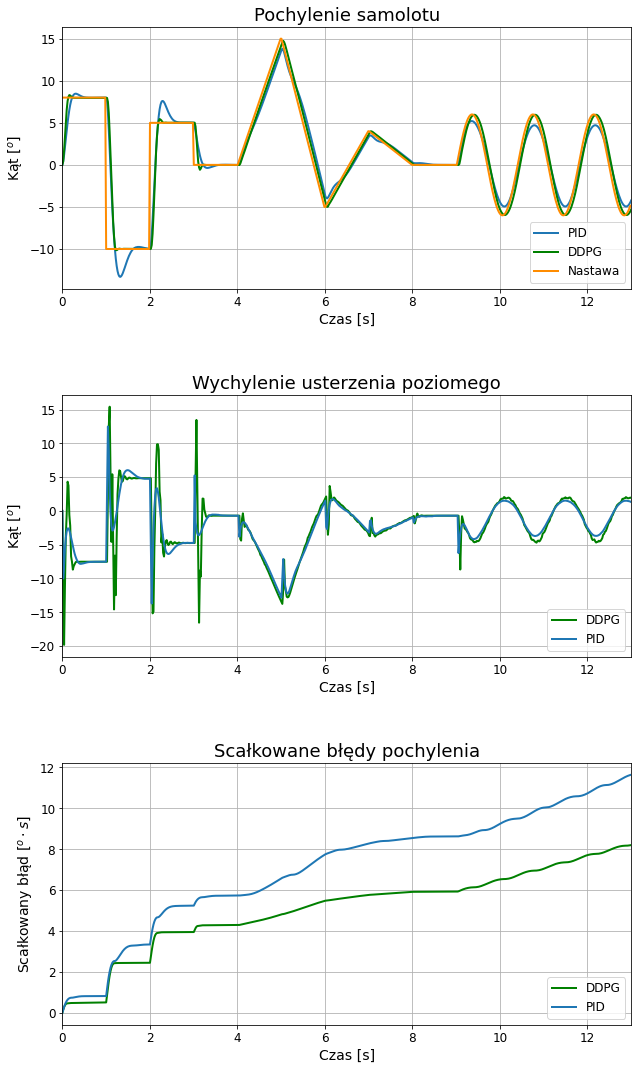

In [18]:
plot_results_comparision(obs_pid=obs_pid, obs_ddpg=obs_ddpg, SP=SP)